In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
import plotly.express as px

##### Uploading Train Dataset

In [3]:
file_path = "final_dataset_b2b_random_subset_churn.csv"
data_train = pd.read_csv(file_path)

In [4]:
columns_to_drop = ['latest_purchase_days_y', 'mean_purchase_frequency_days', 'cluster']
data_train.drop(columns=columns_to_drop, inplace=True)

In [5]:
data_train.rename(columns={'latest_purchase_days_x': 'latest_purchase_days'}, inplace=True)

##### Uploading Test Dataset

In [6]:
file_path = "final_dataset_b2b_remaining_clients_churn.csv"
data_test = pd.read_csv(file_path)

In [7]:
# Specify the columns you want to include
selected_columns = ['client_id','sales_net','quantity', 'product_price','date_order',
                    'order_channel_at the store', 'order_channel_by phone', 'order_channel_during the visit of a sales rep',
                    'order_channel_online', 'order_channel_other']

file_path = "final_dataset_b2b.csv"

data_for_completion = pd.read_csv(file_path, usecols=selected_columns)

In [8]:
data_for_completion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63160893 entries, 0 to 63160892
Data columns (total 10 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   date_order                                     object 
 1   client_id                                      int64  
 2   sales_net                                      float64
 3   quantity                                       int64  
 4   product_price                                  float64
 5   order_channel_at the store                     bool   
 6   order_channel_by phone                         bool   
 7   order_channel_during the visit of a sales rep  bool   
 8   order_channel_online                           bool   
 9   order_channel_other                            bool   
dtypes: bool(5), float64(2), int64(2), object(1)
memory usage: 2.6+ GB


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006791 entries, 0 to 6006790
Data columns (total 18 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   date_order                                     object 
 1   date_invoice                                   object 
 2   product_id                                     int64  
 3   client_id                                      int64  
 4   sales_net                                      float64
 5   quantity                                       int64  
 6   branch_id                                      int64  
 7   product_price                                  float64
 8   order_channel_at the store                     bool   
 9   order_channel_by phone                         bool   
 10  order_channel_during the visit of a sales rep  bool   
 11  order_channel_online                           bool   
 12  order_channel_other                       

In [10]:
# If duplicates are found, you might need to remove them or aggregate your data such that each client_id is unique
data_test = data_test.drop_duplicates(subset=['client_id'])
data_for_completion = data_for_completion.drop_duplicates(subset=['client_id'])

In [11]:
data_test_merged = pd.merge(data_test, data_for_completion, how='left', on='client_id')

# RFM

### Calculate RFM

##### Enter here the dataset to use for the RFM calculation (f.ex. start with the Test Set, do all RFM steps, then come back to do the Train Set)

In [12]:
rfm_data = data_train

In [14]:
rfm_aggregated = rfm_data.groupby('client_id').agg({
    'latest_purchase_days': 'min',               # Recency
    'purchase_frequency': 'mean',      # Frequency
    'sales_net': 'sum'                           # Monetary Value
}).reset_index()

#Renaming columns for clarity
rfm_aggregated.columns = ['client_id', 'recency', 'frequency', 'monetary']

In [15]:
rfm_aggregated

,client_id,recency,frequency,monetary
0,68,58,21.900000,12761.167249
1,227,3,7.511364,82538.014136
2,485,2,2.911647,68426.284500
3,549,2,3.670051,131157.535817
4,795,24,8.345238,18703.021952
...,...,...,...,...
14238,2273961,270,64.000000,1634.609356
14239,2274069,137,23.391304,11245.054405
14240,2274113,12,5.844262,152505.085233
14241,2274279,47,29.478261,7192.240734


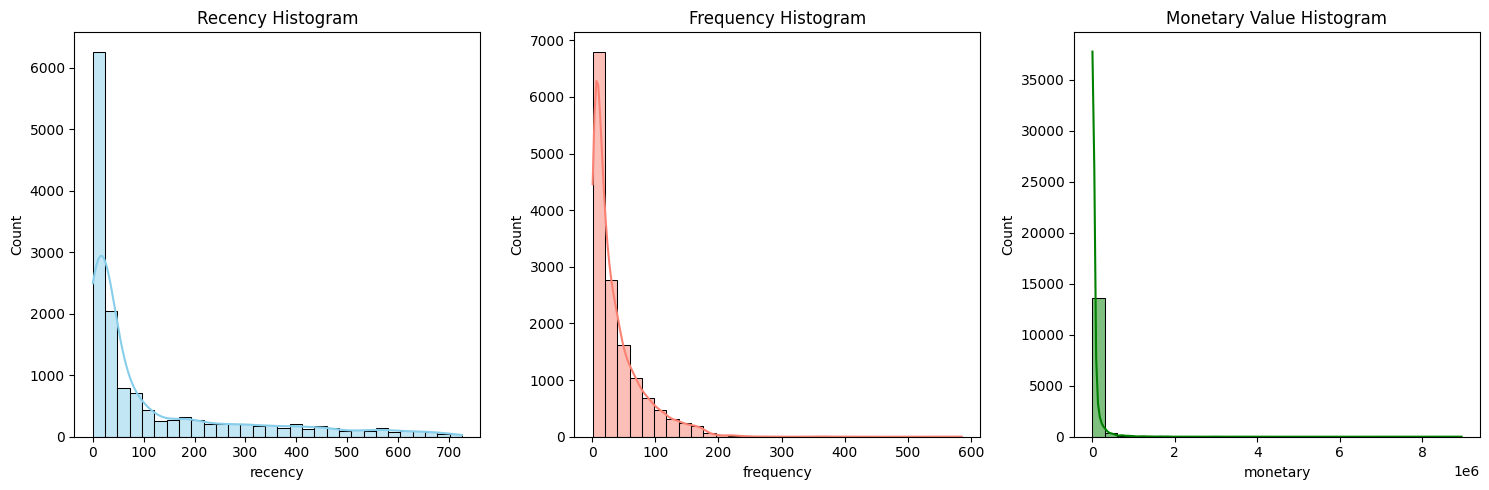

In [16]:
# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for Recency, Frequency, and Monetary Value
sns.histplot(rfm_aggregated['recency'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Histogram')

sns.histplot(rfm_aggregated['frequency'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Frequency Histogram')

sns.histplot(rfm_aggregated['monetary'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Monetary Value Histogram')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

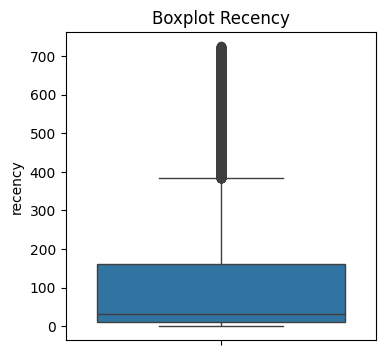

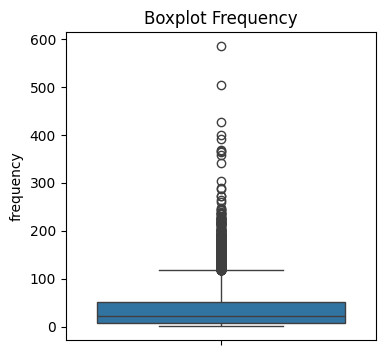

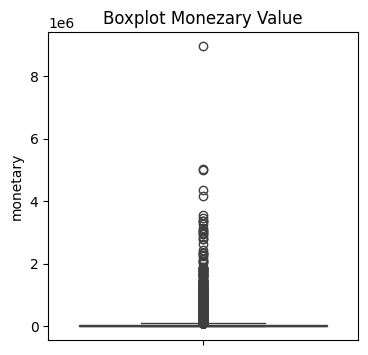

In [17]:
plt.figure(figsize=(4, 4))
sns.boxplot(y=rfm_aggregated['recency'])
plt.title('Boxplot Recency')
plt.show()

plt.figure(figsize=(4, 4))
sns.boxplot(y=rfm_aggregated['frequency'])
plt.title('Boxplot Frequency')
plt.show()

plt.figure(figsize=(4, 4))
sns.boxplot(y=rfm_aggregated['monetary'])
plt.title('Boxplot Monezary Value')
plt.show()

There are many outliers, but the outliers are not "wrong" data points just naturally high, therefore we leave them in.

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
# Scale the separate RFM scores
rfm_variables = rfm_aggregated[['recency', 'frequency', 'monetary']]

# Initialize the RobustScaler
scaler = MinMaxScaler()

# Fit and transform the RFM variables
rfm_standardized = scaler.fit_transform(rfm_variables)

# Create a DataFrame with scaled values
df_standardized = pd.DataFrame(rfm_standardized, columns=['recency_scaled', 'frequency_scaled', 'monetary_scaled'])

# Include the 'client_id' column in the DataFrame
df_standardized['client_id'] = rfm_aggregated['client_id']

# Reorder columns to have 'client_id' up front
df_standardized = df_standardized[['client_id', 'recency_scaled', 'frequency_scaled', 'monetary_scaled']]

In [20]:
# Calculate the RFM scores and add them to the DataFrame
def rfm_scores(dataframe):
    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency_scaled"], 4, labels=[4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(df_["frequency_scaled"].rank(method="first"), 4, labels=[4, 3, 2, 1])
    df_["monetary_score"] = pd.qcut(df_["monetary_scaled"], 4, labels=[1, 2, 3, 4])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(str) + df_["monetary_score"].astype(str)

    return df_

# Apply the function to the DataFrame
df_standardized = rfm_scores(df_standardized)
df_standardized.head()

,client_id,recency_scaled,frequency_scaled,monetary_scaled,recency_score,frequency_score,monetary_score,RFM_SCORE
0,68,0.079890,0.035788,0.001429,2,3,3,233
1,227,0.004132,0.011150,0.009220,4,4,4,444
2,485,0.002755,0.003273,0.007644,4,4,4,444
3,549,0.002755,0.004572,0.014649,4,4,4,444
4,795,0.033058,0.012577,0.002092,3,3,3,333


In [21]:
# Interpret the RFM Score
def segment_customers(row):
    r, f, m = row['RFM_SCORE']

    # Champions
    if r == '4' and f == '4':
        return 'Champions'
    # Loyal Customers
    elif r in ['3', '4'] and f in ['3', '4']:
        return 'Loyal Customers'
    # Potential Loyalist
    elif r in ['2', '3', '4'] and f in ['3', '4']:
        return 'Potential Loyalist'
    # Recent Customers
    elif r == '4':
        return 'Recent Customers'
    # Promising
    elif r == '3':
        return 'Promising'
    # Customers Needing Attention
    elif r == '2' and f in ['3', '4']:
        return 'Customers Needing Attention'
    # About To Sleep
    elif r in ['1', '2'] and f in ['1', '2'] and m in ['3', '4']:
        return 'About To Sleep'
    # At Risk
    elif r == '1' and f in ['3', '4'] and m in ['3', '4']:
        return 'At Risk'
    # Can’t Lose Them
    elif r == '1' and f == '4' and m == '1':
        return 'Can’t Lose Them'
    # Hibernating
    elif r == '1' and f in ['1', '2'] and m in ['1', '2']:
        return 'Hibernating'
    # Lost
    elif r == '1' and f in ['3', '4'] and m in ['3', '4']:
        return 'Lost'
    # Sporadic
    else:
        return 'Sporadic'

# Apply the function to create the new column 'Customer_Type'
df_standardized['Customer_Type'] = df_standardized.apply(segment_customers, axis=1)

df_standardized.head()

,client_id,recency_scaled,frequency_scaled,monetary_scaled,recency_score,frequency_score,monetary_score,RFM_SCORE,Customer_Type
0,68,0.079890,0.035788,0.001429,2,3,3,233,Potential Loyalist
1,227,0.004132,0.011150,0.009220,4,4,4,444,Champions
2,485,0.002755,0.003273,0.007644,4,4,4,444,Champions
3,549,0.002755,0.004572,0.014649,4,4,4,444,Champions
4,795,0.033058,0.012577,0.002092,3,3,3,333,Loyal Customers


In [22]:
customer_segment_counts = df_standardized['Customer_Type'].value_counts().reset_index()
customer_segment_counts.columns = ['Customer_Type', 'Count']

# Create a Treemap
fig = px.treemap(customer_segment_counts, path=['Customer_Type'], values='Count',
                 title='Customer Segmentation Treemap')

fig.show()

![](newplot.png)

In [ ]:
columns_to_drop = ['recency_score', 'monetary_score', 'frequency_score']

df_standardized = df_standardized.drop(columns=columns_to_drop)

##### Merge RFM Scores with the original Dataset

In [ ]:
# Change name based on which Dataset you're currently working on
data_merged_train = pd.merge(rfm_data, df_standardized, on='client_id', how='left')

In [ ]:
data_test_merged.to_csv('data_test_rfm.csv', index=False)

In [ ]:
data_merged_train.to_csv('data_train_rfm.csv')

# Churn Propensity Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

##### Upload previously created datasets

In [ ]:
# Specify the columns you want to include
selected_columns = ['client_id','sales_net', 'RFM_SCORE','quantity', 'product_price',
                    'order_channel_at the store', 'order_channel_by phone', 'order_channel_during the visit of a sales rep',
                    'order_channel_online', 'order_channel_other', 'mean_purchase_frequency_days',
                    'latest_purchase_days', 'churned']

data_train = pd.read_csv('data_train_rfm.csv', usecols=selected_columns)

In [ ]:
# Specify the columns you want to include
selected_columns = ['client_id','sales_net', 'RFM_SCORE','quantity', 'product_price',
                    'order_channel_at the store', 'order_channel_by phone', 'order_channel_during the visit of a sales rep',
                    'order_channel_online', 'order_channel_other', 'mean_purchase_frequency_days',
                    'latest_purchase_days', 'churned']

data_test = pd.read_csv('data_test_rfm.csv', usecols=selected_columns)

In [ ]:
data_train.rename(columns={'latest_purchase_days_x': 'latest_purchase_days'}, inplace=True)

In [ ]:
#Make RFM Score numeric
data_train['RFM_SCORE'] = pd.to_numeric(data_train['RFM_SCORE'], errors='coerce')
data_test['RFM_SCORE'] = pd.to_numeric(data_test['RFM_SCORE'], errors='coerce')

In [ ]:
# Use the entire 'data_merged_train' as the training set
grouped_data_train = data_train.groupby('client_id').agg('mean').reset_index()

# Select relevant columns for modeling
selected_columns_train = ['sales_net', 'RFM_SCORE', 'quantity', 'product_price',
                           'order_channel_at the store', 'order_channel_by phone', 'order_channel_during the visit of a sales rep',
                           'order_channel_online', 'order_channel_other', 'latest_purchase_days', 'std_time_diff','churned']

# Create a new DataFrame with selected columns for training
selected_data_train = grouped_data_train[selected_columns_train].copy()

# Handle missing values if any
selected_data_train = selected_data_train.dropna()

# Separate features (X_train) and target variable (y_train)
X_train = selected_data_train.drop('churned', axis=1)
y_train = selected_data_train['churned']

# Use the entire 'data_merged_test_subset' as the testing set
grouped_data_test = data_test.groupby('client_id').agg('mean').reset_index()

<ipython-input-61-6c666f24d037>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data_train = data_train.groupby('client_id').agg('mean').reset_index()
<ipython-input-61-6c666f24d037>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data_test = data_test.groupby('client_id').agg('mean').reset_index()


In [ ]:
# Use the entire 'data_merged_test_subset' as the testing set
grouped_data_test = data_test.groupby('client_id').agg('mean').reset_index()

# Take a number of rows from 'data_merged_test' equal to 25% of the number of rows in 'data_train'
num_rows_test = int(0.25 * len(grouped_data_train))
data_test_subset = grouped_data_test.sample(n=num_rows_test, random_state=42)

# Select relevant columns for modeling
selected_columns_test = ['sales_net', 'RFM_SCORE', 'quantity', 'product_price',
                          'order_channel_at the store', 'order_channel_by phone', 'order_channel_during the visit of a sales rep',
                          'order_channel_online', 'order_channel_other', 'latest_purchase_days','std_time_diff', 'churned']

# Create a new DataFrame with selected columns for testing
selected_data_test = data_test_subset[selected_columns_test].copy()

# Handle missing values if any
selected_data_test = selected_data_test.dropna()

# Separate features (X_test) and target variable (y_test)
X_test = selected_data_test.drop('churned', axis=1)
y_test = selected_data_test['churned']

<ipython-input-62-22b815466b3d>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data_test = data_test.groupby('client_id').agg('mean').reset_index()


In [ ]:
# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Get the probability estimates for the positive class (churn)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1 (churn)

# Create a new column for predicted probabilities in the testing set DataFrame
selected_data_test['churn_probability'] = y_pred_proba

# Label clients as churned if the probability is higher than the given threshold
threshold = 0.6
selected_data_test['churned'] = (y_pred_proba > threshold).astype(int)

# Evaluate model performance on the testing set
y_pred_binary = (y_pred_proba > 0.6).astype(int)  # Binary predictions based on threshold
print('Performance on the testing set:')
print(classification_report(y_test, y_pred_binary))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_binary))

Performance on the testing set:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2289
         1.0       0.98      0.94      0.96      1038

    accuracy                           0.98      3327
   macro avg       0.98      0.96      0.97      3327
weighted avg       0.98      0.98      0.98      3327

Confusion Matrix:
[[2272   17]
 [  65  973]]


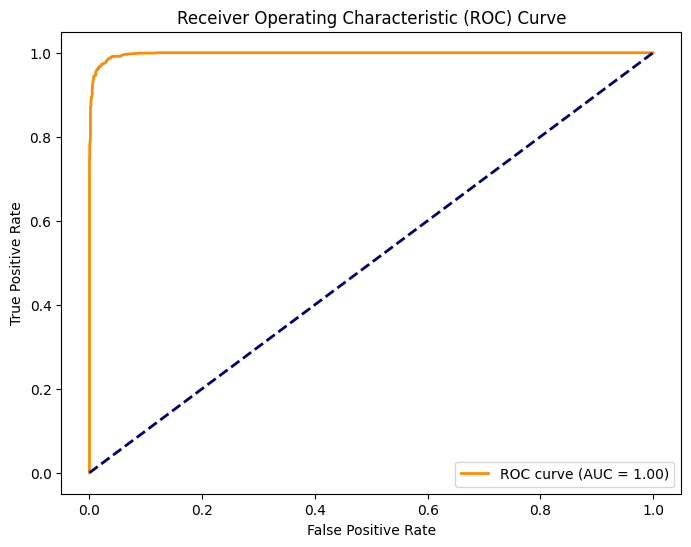

ROC-AUC Score: 0.9978789822481821


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display ROC-AUC score
print('ROC-AUC Score:', roc_auc)

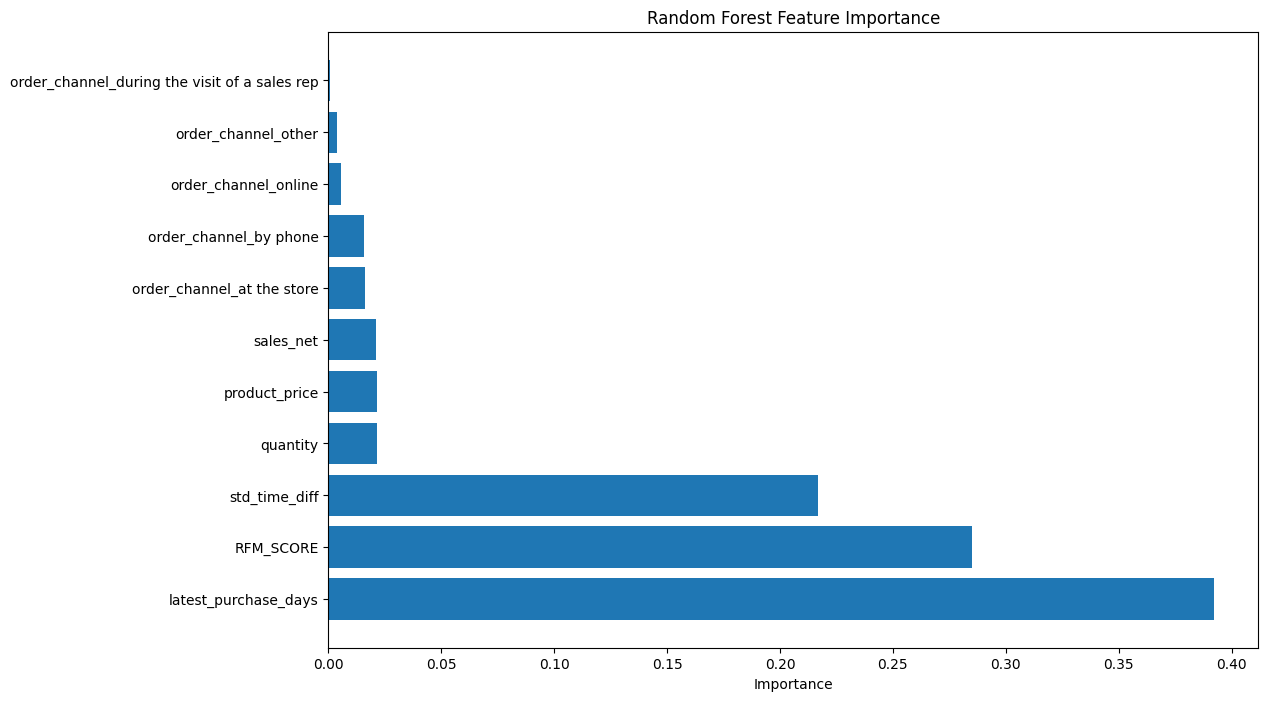

In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to better visualize the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()